In [52]:
import math
import ast
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import tensorflow as tf

import glob
import imageio
import matplotlib.pyplot as plt
import os
import PIL
from tensorflow.keras import layers
import time

import pylab as plt2

import cv2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from pyts.image import RecurrencePlot
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

mms = MinMaxScaler()

In [2]:
def Threshold(List,alpha):
    List2 = List.copy()
    List2.sort()
    m = math.floor(alpha*len(List))
    n = math.ceil(alpha*len(List))
    threshold = (List2[-m]+List2[-n])/2

    plt.figure(figsize = (15, 12))
    plt.plot(List, '.', label = 'Data point')
    plt.xlabel('Data point index')
    plt.ylabel('Reconstruction error')
    plt.axhline(y=threshold, color='r', linestyle='-')
    plt.legend()
    plt.show()
    
    print('\n Threshold: {}'.format(threshold))
    
    Error = list()
    for i in range(len(List)):
        if(List[i] > threshold):
            Error.append(i)
    
    return(Error)

# 1. Train

#### train data

In [53]:
Train=pd.read_csv('Good_chamfer.csv')

In [54]:
for i in range(len(Train)):
    Train.srcData[i] = ast.literal_eval(Train.srcData[i])

C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_14312/2877635443.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Train.srcData[i] = ast.literal_eval(Train.srcData[i])


In [55]:
data = dict(Train.srcData)
data_array = np.array(list(data.values()), dtype = object)
train = mms.fit_transform(data_array.reshape(len(data),len(Train.srcData[0])))

#### test data

In [56]:
Test=pd.read_csv('Test_chamfer.csv')

In [57]:
for i in range(len(Test)):
    Test.srcData[i] = ast.literal_eval(Test.srcData[i])

C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_14312/3432987013.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test.srcData[i] = ast.literal_eval(Test.srcData[i])


In [58]:
data = dict(Test.srcData)
data_array = np.array(list(data.values()), dtype = object)
test = mms.fit_transform(data_array.reshape(len(data),len(Test.srcData[0])))

In [59]:
train.shape, test.shape

((1769, 255), (491, 255))

## a) Recurrence Plot

In [60]:
from pyts.image import RecurrencePlot

transformer = RecurrencePlot(
                dimension=1,
                time_delay=1,
                threshold='point',
                percentage=10,
                flatten=False )

#### RC = train을 이미지화 / RC2 = test를 이미지화

In [61]:
RC = []
for i in range(len(train)//100):
    SlicingSet = transformer.transform(train[100*i:100*(i+1)]).astype('float32')
    for j in range(100):
        resized_image = cv2.resize(SlicingSet[j],(100, 100), interpolation=cv2.INTER_AREA)
        RC.append(resized_image)

SlicingSet = transformer.transform(train[-(len(train)%100):]).astype('float32')
for k in range(len(train)%100):
    resized_image = cv2.resize(SlicingSet[k],(100, 100), interpolation=cv2.INTER_AREA)
    RC.append(resized_image)
    
RC = np.array(RC)

In [62]:
RC2 = []
for i in range(len(test)//100):
    SlicingSet = transformer.transform(test[100*i:100*(i+1)]).astype('float32')
    for j in range(100):
        resized_image = cv2.resize(SlicingSet[j],(100, 100), interpolation=cv2.INTER_AREA)
        RC2.append(resized_image)

SlicingSet = transformer.transform(test[-(len(test)%100):]).astype('float32')
for k in range(len(test)%100):
    resized_image = cv2.resize(SlicingSet[k],(100, 100), interpolation=cv2.INTER_AREA)
    RC2.append(resized_image)
    
RC2 = np.array(RC2)

In [63]:
train_imgs1 = RC.reshape((RC.shape[0],100,100,1))

In [64]:
test_imgs1 = RC2.reshape((RC2.shape[0],100,100,1))

#### a - 1) 오토인코더 학습( CNN버전2_2로 일괄적용)

In [65]:
# Encoder

encoder1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 32, 
                           kernel_size = (3,3), 
                           strides = (2,2), 
                           activation = 'relu',
                           padding = 'SAME',
                           input_shape = (100, 100, 1)),
    
    tf.keras.layers.Conv2D(filters = 64, 
                           kernel_size = (3,3), 
                           strides = (2,2), 
                           activation = 'relu',
                           padding = 'SAME',
                           input_shape = (50, 50, 32)),
    
    tf.keras.layers.Conv2D(filters = 2, 
                           kernel_size = (5,5),
                           padding = 'VALID',
                           input_shape = (25,25,64))
])

encoder1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 50, 50, 32)        320       
                                                                 
 conv2d_10 (Conv2D)          (None, 25, 25, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 21, 21, 2)         3202      
                                                                 
Total params: 22,018
Trainable params: 22,018
Non-trainable params: 0
_________________________________________________________________


In [66]:
# Decoder

decoder1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2DTranspose(filters = 64, 
                                    kernel_size = (5,5),
                                    strides = (1,1), 
                                    activation = 'relu',
                                    padding = 'VALID',
                                    input_shape = (21, 21, 2)),

    tf.keras.layers.Conv2DTranspose(filters = 32, 
                                    kernel_size = (3,3),
                                    strides = (2,2), 
                                    activation = 'relu',
                                    padding = 'SAME',
                                    input_shape = (25, 25, 64)),

    tf.keras.layers.Conv2DTranspose(filters = 1, 
                                    kernel_size = (5,5),
                                    strides = (2,2),
                                    padding = 'SAME',
                                    input_shape = (50,50,32))
])

decoder1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_9 (Conv2DT  (None, 25, 25, 64)       3264      
 ranspose)                                                       
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 50, 50, 32)       18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_11 (Conv2D  (None, 100, 100, 1)      801       
 Transpose)                                                      
                                                                 
Total params: 22,529
Trainable params: 22,529
Non-trainable params: 0
_________________________________________________________________


In [67]:
latent1 = encoder1.output
result1 = decoder1(latent1)

model1 = tf.keras.Model(inputs = encoder1.input, outputs = result1)

model1.compile(optimizer = 'adam',
              loss = 'mean_squared_error')

In [68]:
model1.fit(train_imgs1,train_imgs1, epochs = 10)

Epoch 1/10
56/56 [==============================] - 17s 284ms/step - loss: 0.0263
Epoch 2/10
56/56 [==============================] - 15s 276ms/step - loss: 0.0208
Epoch 3/10
56/56 [==============================] - 16s 277ms/step - loss: 0.0177
Epoch 4/10
56/56 [==============================] - 16s 283ms/step - loss: 0.0166
Epoch 5/10
56/56 [==============================] - 16s 281ms/step - loss: 0.0160
Epoch 6/10
56/56 [==============================] - 16s 276ms/step - loss: 0.0156
Epoch 7/10
56/56 [==============================] - 16s 285ms/step - loss: 0.0153
Epoch 8/10
56/56 [==============================] - 15s 276ms/step - loss: 0.0152
Epoch 9/10
56/56 [==============================] - 15s 276ms/step - loss: 0.0150
Epoch 10/10
56/56 [==============================] - 16s 279ms/step - loss: 0.0149


In [69]:
test_score1 = model1.evaluate(test_imgs1, test_imgs1)
print('Mean Squared Error: {} %'.format(test_score1*100))

16/16 [==============================] - 1s 82ms/step - loss: 0.0153
Mean Squared Error: 1.5316187404096127 %


#### a - 2) 오토인코더 테스트( CNN버전2_2로 일괄적용)

In [70]:
Test_scores1 = list()
for i in range(len(test_imgs1)):
    Test_scores1.append(model1.evaluate(test_imgs1[i].reshape(-1,100,100,1), test_imgs1[i].reshape(-1,100,100,1), verbose = 2))

1/1 - 0s - loss: 0.0146 - 28ms/epoch - 28ms/step
1/1 - 0s - loss: 0.0153 - 30ms/epoch - 30ms/step
1/1 - 0s - loss: 0.0157 - 28ms/epoch - 28ms/step
1/1 - 0s - loss: 0.0143 - 26ms/epoch - 26ms/step
1/1 - 0s - loss: 0.0147 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0155 - 28ms/epoch - 28ms/step
1/1 - 0s - loss: 0.0145 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0143 - 28ms/epoch - 28ms/step
1/1 - 0s - loss: 0.0159 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0150 - 28ms/epoch - 28ms/step
1/1 - 0s - loss: 0.0150 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0150 - 29ms/epoch - 29ms/step
1/1 - 0s - loss: 0.0168 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0145 - 28ms/epoch - 28ms/step
1/1 - 0s - loss: 0.0171 - 36ms/epoch - 36ms/step
1/1 - 0s - loss: 0.0160 - 30ms/epoch - 30ms/step
1/1 - 0s - loss: 0.0159 - 33ms/epoch - 33ms/step
1/1 - 0s - loss: 0.0156 - 33ms/epoch - 33ms/step
1/1 - 0s - loss: 0.0164 - 32ms/epoch - 32ms/step
1/1 - 0s - loss: 0.0173 - 30ms/epoch - 30ms/step
1/1 - 0s - loss: 0.0

1/1 - 0s - loss: 0.0157 - 29ms/epoch - 29ms/step
1/1 - 0s - loss: 0.0162 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0154 - 28ms/epoch - 28ms/step
1/1 - 0s - loss: 0.0183 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0159 - 25ms/epoch - 25ms/step
1/1 - 0s - loss: 0.0165 - 28ms/epoch - 28ms/step
1/1 - 0s - loss: 0.0146 - 29ms/epoch - 29ms/step
1/1 - 0s - loss: 0.0146 - 26ms/epoch - 26ms/step
1/1 - 0s - loss: 0.0145 - 30ms/epoch - 30ms/step
1/1 - 0s - loss: 0.0146 - 30ms/epoch - 30ms/step
1/1 - 0s - loss: 0.0154 - 36ms/epoch - 36ms/step
1/1 - 0s - loss: 0.0148 - 40ms/epoch - 40ms/step
1/1 - 0s - loss: 0.0142 - 47ms/epoch - 47ms/step
1/1 - 0s - loss: 0.0157 - 36ms/epoch - 36ms/step
1/1 - 0s - loss: 0.0153 - 39ms/epoch - 39ms/step
1/1 - 0s - loss: 0.0159 - 42ms/epoch - 42ms/step
1/1 - 0s - loss: 0.0143 - 28ms/epoch - 28ms/step
1/1 - 0s - loss: 0.0164 - 26ms/epoch - 26ms/step
1/1 - 0s - loss: 0.0140 - 28ms/epoch - 28ms/step
1/1 - 0s - loss: 0.0155 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0

1/1 - 0s - loss: 0.0123 - 28ms/epoch - 28ms/step
1/1 - 0s - loss: 0.0148 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0141 - 26ms/epoch - 26ms/step
1/1 - 0s - loss: 0.0152 - 28ms/epoch - 28ms/step
1/1 - 0s - loss: 0.0138 - 28ms/epoch - 28ms/step
1/1 - 0s - loss: 0.0151 - 29ms/epoch - 29ms/step
1/1 - 0s - loss: 0.0146 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0127 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0134 - 29ms/epoch - 29ms/step
1/1 - 0s - loss: 0.0145 - 28ms/epoch - 28ms/step
1/1 - 0s - loss: 0.0167 - 30ms/epoch - 30ms/step
1/1 - 0s - loss: 0.0162 - 30ms/epoch - 30ms/step
1/1 - 0s - loss: 0.0170 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0143 - 26ms/epoch - 26ms/step
1/1 - 0s - loss: 0.0153 - 30ms/epoch - 30ms/step
1/1 - 0s - loss: 0.0162 - 28ms/epoch - 28ms/step
1/1 - 0s - loss: 0.0148 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0149 - 33ms/epoch - 33ms/step
1/1 - 0s - loss: 0.0165 - 33ms/epoch - 33ms/step
1/1 - 0s - loss: 0.0149 - 36ms/epoch - 36ms/step
1/1 - 0s - loss: 0.0

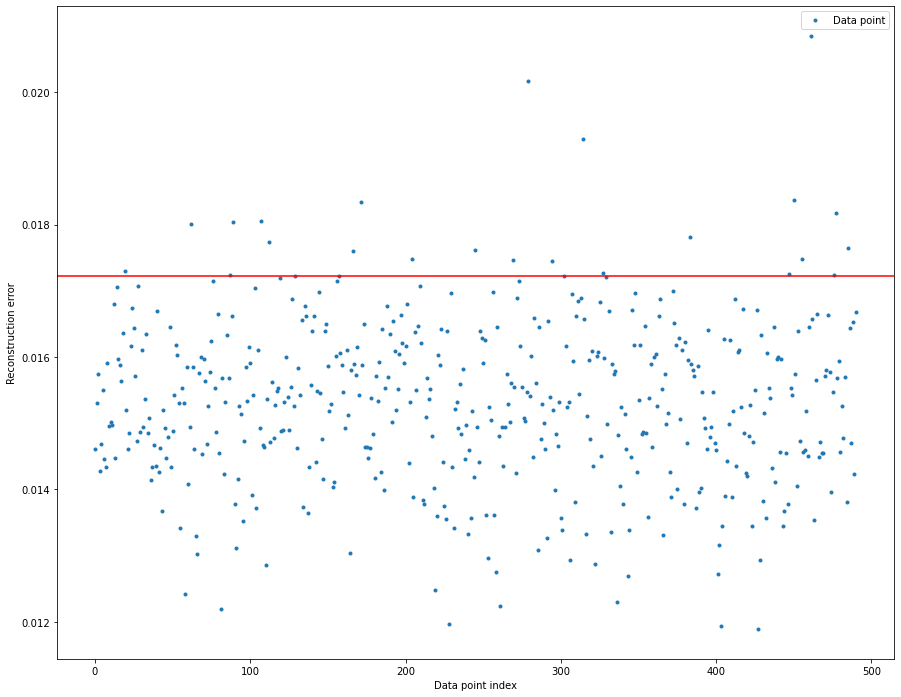


 Threshold: 0.017222140915691853


In [71]:
L1 = Threshold(Test_scores1,alpha=0.05)

## b) Gramian Angular Field

In [72]:
from pyts.image import GramianAngularField

transformer2 = GramianAngularField()

In [73]:
GAF = []
for i in range(len(train)//100):
    SlicingSet = transformer2.transform(train[100*i:100*(i+1)]).astype('float32')
    for j in range(100):
        resized_image = cv2.resize(SlicingSet[j],(100, 100), interpolation=cv2.INTER_AREA)
        GAF.append(resized_image)

SlicingSet = transformer2.transform(train[-(len(train)%100):]).astype('float32')
for k in range(len(train)%100):
    resized_image = cv2.resize(SlicingSet[k],(100, 100), interpolation=cv2.INTER_AREA)
    GAF.append(resized_image)
    
GAF = np.array(GAF)

In [74]:
GAF2 = []
for i in range(len(test)//100):
    SlicingSet = transformer2.transform(test[100*i:100*(i+1)]).astype('float32')
    for j in range(100):
        resized_image = cv2.resize(SlicingSet[j],(100, 100), interpolation=cv2.INTER_AREA)
        GAF2.append(resized_image)

SlicingSet = transformer2.transform(test[-(len(test)%100):]).astype('float32')
for k in range(len(test)%100):
    resized_image = cv2.resize(SlicingSet[k],(100, 100), interpolation=cv2.INTER_AREA)
    GAF2.append(resized_image)
    
GAF2 = np.array(GAF2)

In [75]:
train_imgs2 = GAF.reshape((GAF.shape[0],100,100,1))

In [76]:
test_imgs2 = GAF2.reshape((GAF2.shape[0],100,100,1))

#### b - 1) 오토인코더 학습( CNN버전2_2로 일괄적용)

In [77]:
# Encoder

encoder2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 32, 
                           kernel_size = (3,3), 
                           strides = (2,2), 
                           activation = 'relu',
                           padding = 'SAME',
                           input_shape = (100, 100, 1)),
    
    tf.keras.layers.Conv2D(filters = 64, 
                           kernel_size = (3,3), 
                           strides = (2,2), 
                           activation = 'relu',
                           padding = 'SAME',
                           input_shape = (50, 50, 32)),
    
    tf.keras.layers.Conv2D(filters = 2, 
                           kernel_size = (5,5),
                           padding = 'VALID',
                           input_shape = (25,25,64))
])

encoder2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 50, 50, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 25, 25, 64)        18496     
                                                                 
 conv2d_14 (Conv2D)          (None, 21, 21, 2)         3202      
                                                                 
Total params: 22,018
Trainable params: 22,018
Non-trainable params: 0
_________________________________________________________________


In [78]:
# Decoder

decoder2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2DTranspose(filters = 64, 
                                    kernel_size = (5,5),
                                    strides = (1,1), 
                                    activation = 'relu',
                                    padding = 'VALID',
                                    input_shape = (21, 21, 2)),

    tf.keras.layers.Conv2DTranspose(filters = 32, 
                                    kernel_size = (3,3),
                                    strides = (2,2), 
                                    activation = 'relu',
                                    padding = 'SAME',
                                    input_shape = (25, 25, 64)),

    tf.keras.layers.Conv2DTranspose(filters = 1, 
                                    kernel_size = (5,5),
                                    strides = (2,2),
                                    padding = 'SAME',
                                    input_shape = (50,50,32))
])

decoder2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_12 (Conv2D  (None, 25, 25, 64)       3264      
 Transpose)                                                      
                                                                 
 conv2d_transpose_13 (Conv2D  (None, 50, 50, 32)       18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_14 (Conv2D  (None, 100, 100, 1)      801       
 Transpose)                                                      
                                                                 
Total params: 22,529
Trainable params: 22,529
Non-trainable params: 0
_________________________________________________________________


In [79]:
latent2 = encoder2.output
result2 = decoder2(latent2)

model2 = tf.keras.Model(inputs = encoder2.input, outputs = result2)

model2.compile(optimizer = 'adam',
              loss = 'mean_squared_error')

In [80]:
model2.fit(train_imgs2,train_imgs2, epochs = 10)

Epoch 1/10
56/56 [==============================] - 17s 283ms/step - loss: 0.1719
Epoch 2/10
56/56 [==============================] - 16s 288ms/step - loss: 0.0518
Epoch 3/10
56/56 [==============================] - 16s 278ms/step - loss: 0.0411
Epoch 4/10
56/56 [==============================] - 18s 323ms/step - loss: 0.0356
Epoch 5/10
56/56 [==============================] - 16s 293ms/step - loss: 0.0321
Epoch 6/10
56/56 [==============================] - 16s 280ms/step - loss: 0.0285
Epoch 7/10
56/56 [==============================] - 16s 288ms/step - loss: 0.0258
Epoch 8/10
56/56 [==============================] - 15s 276ms/step - loss: 0.0241
Epoch 9/10
56/56 [==============================] - 16s 294ms/step - loss: 0.0230
Epoch 10/10
56/56 [==============================] - 16s 282ms/step - loss: 0.0221


In [81]:
test_score2 = model2.evaluate(test_imgs2, test_imgs2)
print('Mean Squared Error: {} %'.format(test_score2*100))

16/16 [==============================] - 2s 105ms/step - loss: 0.0247
Mean Squared Error: 2.4737123399972916 %


#### b - 2) 오토인코더 테스트( CNN버전2_2로 일괄적용)

In [82]:
Test_scores2 = list()
for i in range(len(test_imgs2)):
    Test_scores2.append(model2.evaluate(test_imgs2[i].reshape(-1,100,100,1), test_imgs2[i].reshape(-1,100,100,1), verbose = 2))

1/1 - 0s - loss: 0.0118 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0487 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0246 - 33ms/epoch - 33ms/step
1/1 - 0s - loss: 0.0241 - 33ms/epoch - 33ms/step
1/1 - 0s - loss: 0.0346 - 50ms/epoch - 50ms/step
1/1 - 0s - loss: 0.0201 - 40ms/epoch - 40ms/step
1/1 - 0s - loss: 0.0160 - 32ms/epoch - 32ms/step
1/1 - 0s - loss: 0.0260 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0275 - 30ms/epoch - 30ms/step
1/1 - 0s - loss: 0.0550 - 32ms/epoch - 32ms/step
1/1 - 0s - loss: 0.0240 - 43ms/epoch - 43ms/step
1/1 - 0s - loss: 0.0404 - 45ms/epoch - 45ms/step
1/1 - 0s - loss: 0.0454 - 42ms/epoch - 42ms/step
1/1 - 0s - loss: 0.0304 - 49ms/epoch - 49ms/step
1/1 - 0s - loss: 0.0286 - 40ms/epoch - 40ms/step
1/1 - 0s - loss: 0.0173 - 37ms/epoch - 37ms/step
1/1 - 0s - loss: 0.0240 - 28ms/epoch - 28ms/step
1/1 - 0s - loss: 0.0166 - 32ms/epoch - 32ms/step
1/1 - 0s - loss: 0.0280 - 37ms/epoch - 37ms/step
1/1 - 0s - loss: 0.0259 - 32ms/epoch - 32ms/step
1/1 - 0s - loss: 0.0

1/1 - 0s - loss: 0.0207 - 34ms/epoch - 34ms/step
1/1 - 0s - loss: 0.0225 - 33ms/epoch - 33ms/step
1/1 - 0s - loss: 0.0207 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0266 - 29ms/epoch - 29ms/step
1/1 - 0s - loss: 0.0182 - 28ms/epoch - 28ms/step
1/1 - 0s - loss: 0.0201 - 29ms/epoch - 29ms/step
1/1 - 0s - loss: 0.0222 - 29ms/epoch - 29ms/step
1/1 - 0s - loss: 0.0244 - 29ms/epoch - 29ms/step
1/1 - 0s - loss: 0.0233 - 26ms/epoch - 26ms/step
1/1 - 0s - loss: 0.0242 - 26ms/epoch - 26ms/step
1/1 - 0s - loss: 0.0213 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0246 - 31ms/epoch - 31ms/step
1/1 - 0s - loss: 0.0322 - 36ms/epoch - 36ms/step
1/1 - 0s - loss: 0.0190 - 46ms/epoch - 46ms/step
1/1 - 0s - loss: 0.0151 - 48ms/epoch - 48ms/step
1/1 - 0s - loss: 0.0249 - 44ms/epoch - 44ms/step
1/1 - 0s - loss: 0.0265 - 50ms/epoch - 50ms/step
1/1 - 0s - loss: 0.0135 - 45ms/epoch - 45ms/step
1/1 - 0s - loss: 0.0112 - 36ms/epoch - 36ms/step
1/1 - 0s - loss: 0.0208 - 34ms/epoch - 34ms/step
1/1 - 0s - loss: 0.0

1/1 - 0s - loss: 0.0170 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0184 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0084 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0336 - 28ms/epoch - 28ms/step
1/1 - 0s - loss: 0.0300 - 32ms/epoch - 32ms/step
1/1 - 0s - loss: 0.0287 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0383 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0161 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0302 - 34ms/epoch - 34ms/step
1/1 - 0s - loss: 0.0442 - 29ms/epoch - 29ms/step
1/1 - 0s - loss: 0.0156 - 29ms/epoch - 29ms/step
1/1 - 0s - loss: 0.0261 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0225 - 29ms/epoch - 29ms/step
1/1 - 0s - loss: 0.0251 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0108 - 29ms/epoch - 29ms/step
1/1 - 0s - loss: 0.0179 - 30ms/epoch - 30ms/step
1/1 - 0s - loss: 0.0284 - 36ms/epoch - 36ms/step
1/1 - 0s - loss: 0.0173 - 30ms/epoch - 30ms/step
1/1 - 0s - loss: 0.0234 - 34ms/epoch - 34ms/step
1/1 - 0s - loss: 0.0219 - 29ms/epoch - 29ms/step
1/1 - 0s - loss: 0.0

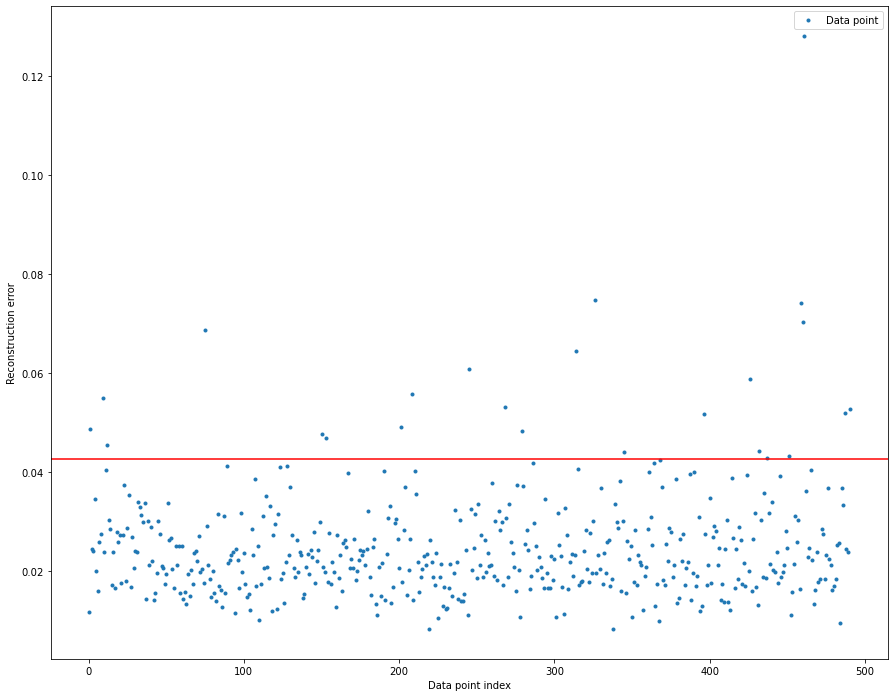


 Threshold: 0.04267270676791668


In [83]:
L2 = Threshold(Test_scores2,alpha=0.05)

## c) MarkovTransitionField

In [84]:
from pyts.image import MarkovTransitionField
transformer3 = MarkovTransitionField()

In [85]:
MT = []
for i in range(len(train)//100):
    SlicingSet = transformer3.transform(train[100*i:100*(i+1)]).astype('float32')
    for j in range(100):
        resized_image = cv2.resize(SlicingSet[j],(100, 100), interpolation=cv2.INTER_AREA)
        MT.append(resized_image)

SlicingSet = transformer3.transform(train[-(len(train)%100):]).astype('float32')
for k in range(len(train)%100):
    resized_image = cv2.resize(SlicingSet[k],(100, 100), interpolation=cv2.INTER_AREA)
    MT.append(resized_image)
    
MT = np.array(MT)

C:\Users\sangmin\anaconda3\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [3]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
C:\Users\sangmin\anaconda3\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [3 4]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
C:\Users\sangmin\anaconda3\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [2 5]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
C:\Users\sangmin\anaconda3\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning:

In [86]:
MT2 = []
for i in range(len(test)//100):
    SlicingSet = transformer3.transform(test[100*i:100*(i+1)]).astype('float32')
    for j in range(100):
        resized_image = cv2.resize(SlicingSet[j],(100, 100), interpolation=cv2.INTER_AREA)
        MT2.append(resized_image)

SlicingSet = transformer3.transform(test[-(len(test)%100):]).astype('float32')
for k in range(len(test)%100):
    resized_image = cv2.resize(SlicingSet[k],(100, 100), interpolation=cv2.INTER_AREA)
    MT2.append(resized_image)
    
MT2 = np.array(MT2)

C:\Users\sangmin\anaconda3\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [2 4]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
C:\Users\sangmin\anaconda3\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [2 4]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
C:\Users\sangmin\anaconda3\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [3 4]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
C:\Users\sangmin\anaconda3\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarnin

In [87]:
train_imgs3 = MT.reshape((MT.shape[0],100,100,1))

In [88]:
test_imgs3 = MT2.reshape((MT2.shape[0],100,100,1))

#### c - 1) 오토인코더 학습( CNN버전2_2로 일괄적용)

In [89]:
# Encoder

encoder3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 32, 
                           kernel_size = (3,3), 
                           strides = (2,2), 
                           activation = 'relu',
                           padding = 'SAME',
                           input_shape = (100, 100, 1)),
    
    tf.keras.layers.Conv2D(filters = 64, 
                           kernel_size = (3,3), 
                           strides = (2,2), 
                           activation = 'relu',
                           padding = 'SAME',
                           input_shape = (50, 50, 32)),
    
    tf.keras.layers.Conv2D(filters = 2, 
                           kernel_size = (5,5),
                           padding = 'VALID',
                           input_shape = (25,25,64))
])

encoder3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 50, 50, 32)        320       
                                                                 
 conv2d_16 (Conv2D)          (None, 25, 25, 64)        18496     
                                                                 
 conv2d_17 (Conv2D)          (None, 21, 21, 2)         3202      
                                                                 
Total params: 22,018
Trainable params: 22,018
Non-trainable params: 0
_________________________________________________________________


In [90]:
# Decoder

decoder3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2DTranspose(filters = 64, 
                                    kernel_size = (5,5),
                                    strides = (1,1), 
                                    activation = 'relu',
                                    padding = 'VALID',
                                    input_shape = (21, 21, 2)),

    tf.keras.layers.Conv2DTranspose(filters = 32, 
                                    kernel_size = (3,3),
                                    strides = (2,2), 
                                    activation = 'relu',
                                    padding = 'SAME',
                                    input_shape = (25, 25, 64)),

    tf.keras.layers.Conv2DTranspose(filters = 1, 
                                    kernel_size = (5,5),
                                    strides = (2,2),
                                    padding = 'SAME',
                                    input_shape = (50,50,32))
])

decoder3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_15 (Conv2D  (None, 25, 25, 64)       3264      
 Transpose)                                                      
                                                                 
 conv2d_transpose_16 (Conv2D  (None, 50, 50, 32)       18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_17 (Conv2D  (None, 100, 100, 1)      801       
 Transpose)                                                      
                                                                 
Total params: 22,529
Trainable params: 22,529
Non-trainable params: 0
_________________________________________________________________


In [91]:
latent3 = encoder3.output
result3 = decoder3(latent3)

model3 = tf.keras.Model(inputs = encoder3.input, outputs = result3)

model3.compile(optimizer = 'adam',
              loss = 'mean_squared_error')

In [92]:
model3.fit(train_imgs3,train_imgs3, epochs = 10)

Epoch 1/10
56/56 [==============================] - 17s 281ms/step - loss: 0.0153
Epoch 2/10
56/56 [==============================] - 20s 349ms/step - loss: 0.0112
Epoch 3/10
56/56 [==============================] - 19s 345ms/step - loss: 0.0086
Epoch 4/10
56/56 [==============================] - 21s 371ms/step - loss: 0.0075
Epoch 5/10
56/56 [==============================] - 19s 337ms/step - loss: 0.0071
Epoch 6/10
56/56 [==============================] - 17s 303ms/step - loss: 0.0067
Epoch 7/10
56/56 [==============================] - 18s 326ms/step - loss: 0.0065
Epoch 8/10
56/56 [==============================] - 22s 384ms/step - loss: 0.0063
Epoch 9/10
56/56 [==============================] - 21s 381ms/step - loss: 0.0062
Epoch 10/10
56/56 [==============================] - 17s 303ms/step - loss: 0.0061


In [93]:
test_score3 = model3.evaluate(test_imgs3, test_imgs3)
print('Mean Squared Error: {} %'.format(test_score3*100))

16/16 [==============================] - 1s 73ms/step - loss: 0.0061
Mean Squared Error: 0.6053979508578777 %


#### c - 2) 오토인코더 테스트( CNN버전2_2로 일괄적용)

In [94]:
Test_scores3 = list()
for i in range(len(test_imgs3)):
    Test_scores3.append(model3.evaluate(test_imgs3[i].reshape(-1,100,100,1), test_imgs3[i].reshape(-1,100,100,1), verbose = 2))

1/1 - 0s - loss: 0.0042 - 26ms/epoch - 26ms/step
1/1 - 0s - loss: 0.0057 - 38ms/epoch - 38ms/step
1/1 - 0s - loss: 0.0067 - 38ms/epoch - 38ms/step
1/1 - 0s - loss: 0.0071 - 26ms/epoch - 26ms/step
1/1 - 0s - loss: 0.0052 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0074 - 30ms/epoch - 30ms/step
1/1 - 0s - loss: 0.0055 - 30ms/epoch - 30ms/step
1/1 - 0s - loss: 0.0057 - 25ms/epoch - 25ms/step
1/1 - 0s - loss: 0.0075 - 30ms/epoch - 30ms/step
1/1 - 0s - loss: 0.0035 - 29ms/epoch - 29ms/step
1/1 - 0s - loss: 0.0052 - 26ms/epoch - 26ms/step
1/1 - 0s - loss: 0.0074 - 26ms/epoch - 26ms/step
1/1 - 0s - loss: 0.0056 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0047 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0068 - 28ms/epoch - 28ms/step
1/1 - 0s - loss: 0.0061 - 25ms/epoch - 25ms/step
1/1 - 0s - loss: 0.0055 - 28ms/epoch - 28ms/step
1/1 - 0s - loss: 0.0062 - 28ms/epoch - 28ms/step
1/1 - 0s - loss: 0.0064 - 32ms/epoch - 32ms/step
1/1 - 0s - loss: 0.0083 - 30ms/epoch - 30ms/step
1/1 - 0s - loss: 0.0

1/1 - 0s - loss: 0.0057 - 26ms/epoch - 26ms/step
1/1 - 0s - loss: 0.0061 - 31ms/epoch - 31ms/step
1/1 - 0s - loss: 0.0070 - 30ms/epoch - 30ms/step
1/1 - 0s - loss: 0.0067 - 26ms/epoch - 26ms/step
1/1 - 0s - loss: 0.0094 - 29ms/epoch - 29ms/step
1/1 - 0s - loss: 0.0060 - 26ms/epoch - 26ms/step
1/1 - 0s - loss: 0.0043 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0049 - 28ms/epoch - 28ms/step
1/1 - 0s - loss: 0.0048 - 28ms/epoch - 28ms/step
1/1 - 0s - loss: 0.0051 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0068 - 25ms/epoch - 25ms/step
1/1 - 0s - loss: 0.0083 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0057 - 26ms/epoch - 26ms/step
1/1 - 0s - loss: 0.0076 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0046 - 28ms/epoch - 28ms/step
1/1 - 0s - loss: 0.0076 - 29ms/epoch - 29ms/step
1/1 - 0s - loss: 0.0054 - 48ms/epoch - 48ms/step
1/1 - 0s - loss: 0.0068 - 52ms/epoch - 52ms/step
1/1 - 0s - loss: 0.0054 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0058 - 28ms/epoch - 28ms/step
1/1 - 0s - loss: 0.0

1/1 - 0s - loss: 0.0052 - 29ms/epoch - 29ms/step
1/1 - 0s - loss: 0.0063 - 31ms/epoch - 31ms/step
1/1 - 0s - loss: 0.0054 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0068 - 26ms/epoch - 26ms/step
1/1 - 0s - loss: 0.0033 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0056 - 28ms/epoch - 28ms/step
1/1 - 0s - loss: 0.0074 - 28ms/epoch - 28ms/step
1/1 - 0s - loss: 0.0060 - 26ms/epoch - 26ms/step
1/1 - 0s - loss: 0.0058 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0062 - 29ms/epoch - 29ms/step
1/1 - 0s - loss: 0.0074 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0060 - 30ms/epoch - 30ms/step
1/1 - 0s - loss: 0.0086 - 30ms/epoch - 30ms/step
1/1 - 0s - loss: 0.0051 - 28ms/epoch - 28ms/step
1/1 - 0s - loss: 0.0051 - 31ms/epoch - 31ms/step
1/1 - 0s - loss: 0.0053 - 27ms/epoch - 27ms/step
1/1 - 0s - loss: 0.0053 - 31ms/epoch - 31ms/step
1/1 - 0s - loss: 0.0051 - 31ms/epoch - 31ms/step
1/1 - 0s - loss: 0.0070 - 31ms/epoch - 31ms/step
1/1 - 0s - loss: 0.0045 - 42ms/epoch - 42ms/step
1/1 - 0s - loss: 0.0

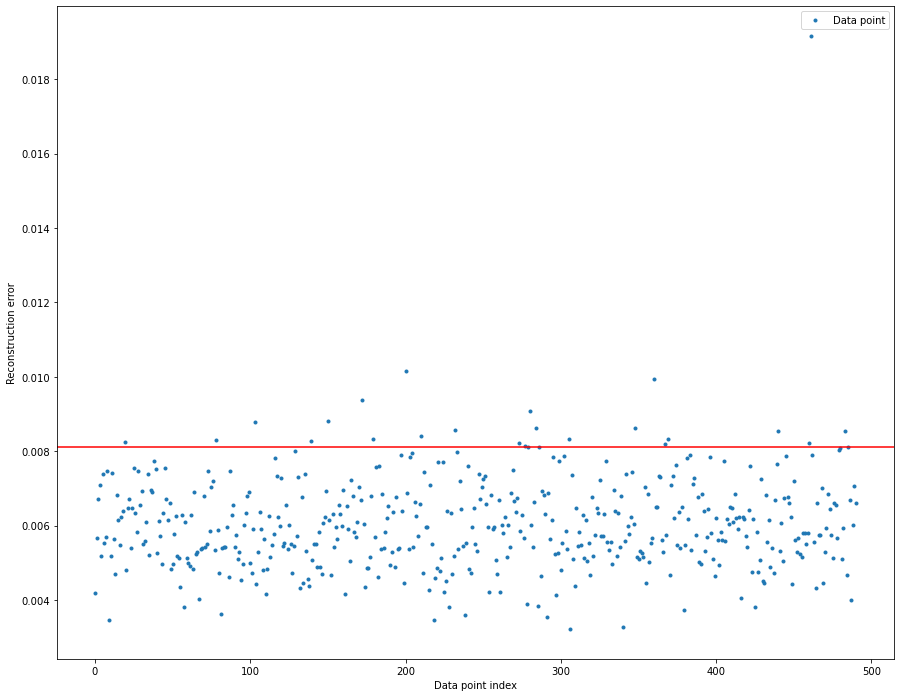


 Threshold: 0.008109041955322027


In [95]:
L3 = Threshold(Test_scores3,alpha=0.05)

In [96]:
set1 = set(L1)
set2 = set(L2)
set3 = set(L3)

In [97]:
print(set1)

{269, 19, 279, 166, 294, 171, 302, 314, 62, 447, 450, 327, 455, 204, 461, 87, 89, 476, 477, 485, 107, 112, 245, 383}


In [98]:
print(set2)

{1, 9, 12, 268, 396, 150, 279, 153, 426, 432, 437, 314, 451, 326, 201, 75, 459, 460, 461, 208, 345, 487, 490, 245}


In [99]:
print(set3)

{139, 273, 19, 277, 150, 280, 284, 286, 172, 305, 179, 440, 200, 460, 461, 78, 210, 348, 483, 103, 232, 360, 367, 369}


In [100]:
print(set1 & set2 & set3)

{461}


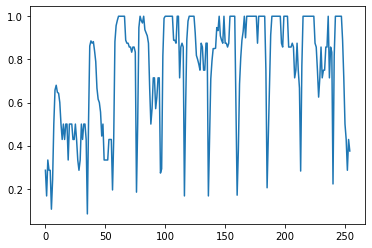

In [101]:
plt.plot(test[461])